In [2]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

import csv
import requests
import xml.etree.ElementTree as ET

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from PIL import Image

In [3]:
# Image dataset of approximate segmentations
class ImageDataset(Dataset):
    def __init__(self, img_patches, p_in_bounds, gpu=False):
        self.img_patches = torch.tensor(img_patches).float()
        self.p_within_bounds = torch.tensor(p_in_bounds).float()

        if gpu:
            self.img_patches = self.img_patches.cuda()
            self.p_within_bounds = self.p_within_bounds.cuda()

    def __len__(self):
        return self.img_patches.shape[0]

    def __getitem__(self, idx):
        return self.img_patches[idx], self.p_within_bounds[idx]

In [4]:
def get_noise(shape, noise_scale_factor):
    noise = np.random.normal(0, 1, [s // noise_scale_factor for s in shape])
    noise = 1 / (1 + np.exp(noise))
    noise = cv2.resize(noise, tuple(reversed(shape)))
    return noise

In [5]:
def cluster_img(img, k, c=3, n=10, t=1.):
    img *= 255.
    vectorized = np.float32(img.reshape((-1,c)))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, n, t)

    attempts=10
    ret, label, center = cv2.kmeans(vectorized, k, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))
    return result_image / 255.

In [6]:
IMAGES_DIR = "data/wild/ImageDataset/Images/"
ACTIVATION_MAPS_DIR = "data/wild/ImageDataset/ActivationMaps/"

USE_GPU = True
imgs = []
maps = []
noisy_maps = []
bin_maps = []

# Load images
for annotation_index, annotation_file in enumerate(os.listdir(IMAGES_DIR)):
    img = torch.tensor(np.moveaxis(cv2.imread(os.path.join(IMAGES_DIR, annotation_file)) / 255., -1, 0)).float()
    if USE_GPU:
        img = img.cuda()

    img_index = int(annotation_file.split("/")[-1].split(".")[0])
    imgs.append((img_index, img))

# Load activation maps
for annotation_index, annotation_file in enumerate(os.listdir(ACTIVATION_MAPS_DIR)):
    map_np = np.moveaxis(cv2.imread(os.path.join(ACTIVATION_MAPS_DIR, annotation_file)) / 255., -1, 0)[:1]

    map = torch.tensor(map_np).float()
    noisy_map = torch.tensor(np.expand_dims(map_np[0] + get_noise(map_np[0].shape, 14), axis=0) / 2).float()
    bin_map = torch.tensor(cluster_img(map_np, 3, 1) > 0.5).float()

    if USE_GPU:
        map = map.cuda()
        noisy_map = noisy_map.cuda()
        bin_map = bin_map.cuda()

    img_index = int(annotation_file.split("/")[-1].split(".")[0])
    maps.append((img_index, map))
    noisy_maps.append((img_index, noisy_map))
    bin_maps.append((img_index, bin_map))


# Sort imgs
imgs.sort(key=lambda x:x[0])
maps.sort(key=lambda x:x[0])
noisy_maps.sort(key=lambda x:x[0])
bin_maps.sort(key=lambda x:x[0])

Segmentation Autoencoder

In [7]:
class SegmentationAutoencoder(nn.Module):
    def __init__(self, n_channels, enc_layer_dims, dec_layer_dims, k):
        super().__init__()
        
        self.conv_in = nn.Conv2d(n_channels, enc_layer_dims[0], 5, padding=2)
        self.conv_out = nn.Conv2d(dec_layer_dims[-1], 1, 5, padding=2)

        self.enc_conv_layers = nn.ModuleList([nn.Conv2d(enc_layer_dims[i], enc_layer_dims[i+1], k, padding=k//2) for i in range(len(enc_layer_dims)-1)])
        self.dec_conv_layers = nn.ModuleList([nn.Conv2d(dec_layer_dims[i], dec_layer_dims[i+1], k, padding=k//2) for i in range(len(enc_layer_dims)-1)])

        self.pool = nn.MaxPool2d(2, 2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def pad_to_input_shape(self, in_tensor, out_tensor):
        left = math.floor((in_tensor.shape[-2] - out_tensor.shape[-2]) / 2.)
        right = math.ceil((in_tensor.shape[-2] - out_tensor.shape[-2]) / 2.)
        top = math.floor((in_tensor.shape[-1] - out_tensor.shape[-1]) / 2.)
        bottom = math.ceil((in_tensor.shape[-1] - out_tensor.shape[-1]) / 2.)

        return F.pad(out_tensor, (top, bottom, left, right), mode='constant', value=0)
    
    def enc_forward(self, x):
        x = self.pool(F.relu(self.conv_in(x)))
        for i, layer in enumerate(self.enc_conv_layers):
            x = self.pool(F.relu(layer(x)))
        return x

    def dec_forward(self, x):
        x = self.upsample(x)
        for i, layer in enumerate(self.dec_conv_layers):
            x = self.pool(F.relu(layer(x)))
        return x

    def forward(self, x):
        x_in = x.clone()
        x = self.enc_forward(x)
        x = self.dec_forward(x)
        x = self.pad_to_input_shape(x_in, x)
        x = self.conv_out(x)
        return x

In [8]:
model = SegmentationAutoencoder(3, [32, 16, 10, 10], [10, 10, 16, 32], 3)

if USE_GPU:
    model = model.cuda()

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
def train_segmentation_model(model, criterion, optimizer, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        epoch_losses = []
        for x_data, y_data in zip(imgs, noisy_maps):
            x = x_data[1]
            y = y_data[1]

            y_pred = model(torch.unsqueeze(x, dim=0))[0]
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_losses.append(loss.item())

        epoch_loss = sum(epoch_losses) / len(epoch_losses)
        print(epoch_loss)

In [10]:
train_segmentation_model(model, criterion, optimizer, 10)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


0.05901971481507644
0.02511024388950318
0.02449108719592914
0.02449152615154162
0.024492563912644982


KeyboardInterrupt: ignored

In [ ]:
i = 29

#model.eval()

plt.imshow(imgs[i][1].cpu().numpy()[0])
plt.show()

plt.imshow(maps[i][1].cpu().numpy()[0])
plt.show()

plt.imshow(noisy_maps[i][1].cpu().numpy()[0])
plt.show()

plt.imshow(bin_maps[i][1].cpu().numpy()[0])
plt.show()

plt.imshow(model(torch.unsqueeze(imgs[i][1], dim=0))[0].detach().cpu().numpy()[0])
plt.show()

## Segment Mapper

In [117]:
class SegmentationMapper(nn.Module):
    def __init__(self, n_channels, layer_dims, k, pool="avg"):
        super().__init__()
        
        self.conv_in = nn.Conv2d(n_channels, layer_dims[0], 5, padding=2)
        self.conv_out = nn.Conv2d(layer_dims[-1], 1, 5, padding=2)

        self.conv_layers = nn.ModuleList([nn.Conv2d(layer_dims[i], layer_dims[i+1], k, padding=k//2) for i in range(len(layer_dims)-1)])

        if pool == "avg":
            self.pool = nn.AvgPool2d(2, 2)
        else:
            self.pool = nn.MaxPool2d(2, 2)

    def pad_to_input_shape(self, in_tensor, out_tensor):
        left = math.floor((in_tensor.shape[-2] - out_tensor.shape[-2]) / 2.)
        right = math.ceil((in_tensor.shape[-2] - out_tensor.shape[-2]) / 2.)
        top = math.floor((in_tensor.shape[-1] - out_tensor.shape[-1]) / 2.)
        bottom = math.ceil((in_tensor.shape[-1] - out_tensor.shape[-1]) / 2.)

        return F.pad(out_tensor, (top, bottom, left, right), mode='constant', value=0)
    
    def scale_segmentation(self, x):
        x = self.pool(x)
        for layer in self.conv_layers:
            x = self.pool(x)
        return x

    def forward(self, x, l=-1):
        x = self.pool(F.relu(self.conv_in(x)))
        for i, layer in enumerate(self.conv_layers):
            if i == l:
                return F.sigmoid(x)
            x = self.pool(F.relu(layer(x)))
        x = F.sigmoid(self.conv_out(x))
        return x

In [79]:
def train_segmentation_classifier_model(model, segs, criterion, optimizer, n_epochs):
    model.train()
    for epoch in range(n_epochs):
        epoch_losses = []
        for x_data, y_data in zip(imgs, segs):
            x = x_data[1]
            y = y_data[1]

            y_pred = model(torch.unsqueeze(x, dim=0))[0]
            y = model.scale_segmentation(torch.unsqueeze(y, dim=0))[0]
            
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_losses.append(loss.item())

        epoch_loss = sum(epoch_losses) / len(epoch_losses)
        print(epoch_loss)

In [134]:
model = SegmentationMapper(n_channels=3, layer_dims=[32, 24, 16, 8], k=3, pool="max")

if USE_GPU:
    model = model.cuda()

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [138]:
train_segmentation_classifier_model(model, noisy_maps, criterion, optimizer, 50)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.025888614763971418
0.025882512738462538
0.02587633163202554
0.025870065577328204
0.025863708520773798
0.025857250113040207
0.025850681727752088
0.025843997218180446
0.025837179063819347
0.025830223166849464
0.025823114986997096
0.02581584529252723
0.025808397808577865
0.025800759543199093
0.025792913045734167
0.025784847466275095
0.02577654756605625
0.025767992692999543
0.025759170146193354
0.0257500508450903


KeyboardInterrupt: ignored

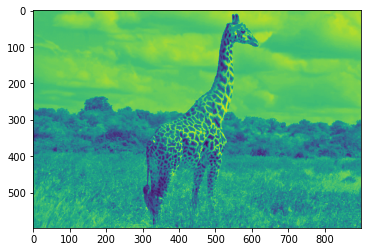

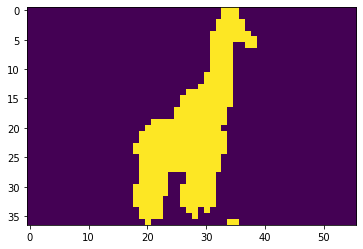

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


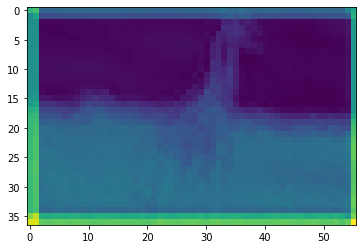

In [139]:
i = 56

model.eval()

plt.imshow(imgs[i][1].cpu().numpy()[0])
plt.show()

plt.imshow(model.scale_segmentation(bin_maps[i][1]).cpu().numpy()[0])
plt.show()

plt.imshow(model(torch.unsqueeze(imgs[i][1], dim=0))[0].detach().cpu().numpy()[0])
plt.show()